In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

C:\Users\lenovo-pc\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_classes = 2
input_shape = (201, 201, 3)

In [3]:
TRAINING_DIR = ('F:\\SIC50\\SIC50imagesRaw_1\\Cephalotaxine\\con3ctrl\\train')
training_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
VALIDATION_DIR = ('F:\\SIC50\\SIC50imagesRaw_1\\Cephalotaxine\\con3ctrl\\test')
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(201,201),
	class_mode='binary',
  batch_size=200
)

Found 5040 images belonging to 2 classes.


In [6]:
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(201,201),
	class_mode='binary',
  batch_size=200
)

Found 560 images belonging to 2 classes.


In [7]:
x_train, y_train = train_generator.next()
x_test, y_test = validation_generator.next()

In [8]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (200, 201, 201, 3) - y_train shape: (200,)
x_test shape: (200, 201, 201, 3) - y_test shape: (200,)


In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 200
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


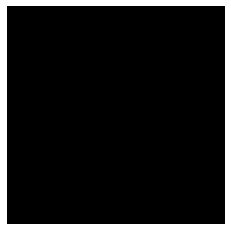

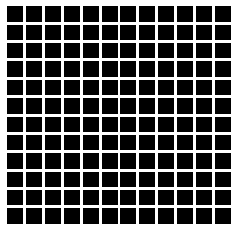

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [15]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [16]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
 
    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.2954 - accuracy: 0.5056 - val_loss: 3.9570 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 5.6209 - accuracy: 0.5444 - val_loss: 8.1469 - val_accuracy: 0.6500
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 11.8765 - accuracy: 0.5222 - val_loss: 2.2960 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 2.5045 - accuracy: 0.4778 - val_loss: 8.2329 - val_accuracy: 0.3500
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 6.5479 - accuracy: 0.4944 - val_loss: 0.8874 - val_accuracy: 0.7000
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 1.4406 - accuracy: 0.5333 - val_loss: 1.3363 - val_accuracy: 0.6000
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 1.9459 - accuracy: 0.5611 - val_loss: 1.8303 - val_accuracy: 0.5000
Epoch 8/100
1/1 [==============

Epoch 60/100
1/1 [==============================] - 4s 4s/step - loss: 0.3899 - accuracy: 0.8056 - val_loss: 0.4390 - val_accuracy: 0.7000
Epoch 61/100
1/1 [==============================] - 4s 4s/step - loss: 0.4118 - accuracy: 0.7944 - val_loss: 0.3930 - val_accuracy: 0.8500
Epoch 62/100
1/1 [==============================] - 4s 4s/step - loss: 0.4530 - accuracy: 0.8111 - val_loss: 0.3829 - val_accuracy: 0.8500
Epoch 63/100
1/1 [==============================] - 4s 4s/step - loss: 0.4737 - accuracy: 0.8222 - val_loss: 0.4442 - val_accuracy: 0.6500
Epoch 64/100
1/1 [==============================] - 4s 4s/step - loss: 0.4732 - accuracy: 0.7722 - val_loss: 0.3925 - val_accuracy: 0.7500
Epoch 65/100
1/1 [==============================] - 5s 5s/step - loss: 0.4503 - accuracy: 0.7778 - val_loss: 0.3262 - val_accuracy: 0.7500
Epoch 66/100
1/1 [==============================] - 4s 4s/step - loss: 0.4881 - accuracy: 0.7444 - val_loss: 0.3464 - val_accuracy: 0.7500
Epoch 67/100
1/1 [=========